Built with sklearn v0.22.2

# Model Explainability Based on Traditional Statistical Principles

In [1]:
import sklearn
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
print(sklearn.__version__)

1.0.2


## Load and Explore Boston Housing Data

The goal is to predict median value of owner-occupied homes in $1000s ***AND*** to understand what influences home value.

In [3]:
from sklearn import datasets
data = datasets.load_boston()
df = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.DataFrame(data.target, columns=["MEDV"])

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

##### View details of the data

In [4]:
print(data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Looking for biases and ethical problems in data is important. 
Dropping column 'B' here to prevent racially biased and unethical analyses.

In [5]:
df.drop(['B'], axis=1, inplace=True)

In [6]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,5.33


A function to produce a quick summary of the columns in a dataframe

In [7]:
# input a dataframe
# returns a dataframe with helpful statistics on the dataframe and its columns
# modified for py3

def dqr(d):
    #data types
    dqr_data_types = pd.DataFrame(d.dtypes, columns=['data_type'])

    #percent missing
    dqr_percent_missing = pd.DataFrame(100*(d.isnull().sum()/len(d)).round(3), columns=['perc_missing'])

    #unique values
    dqr_unique_values = pd.DataFrame(columns=['unique_values'])
    for c in d:
        dqr_unique_values.loc[c]=d[c].nunique()
        
    #mode
    dqr_mode = pd.DataFrame(d.mode().loc[0])
    dqr_mode.rename(columns={ dqr_mode.columns[0]: "mode" }, inplace=True)
    
    #count mode
    dqr_count_mode = pd.DataFrame(columns=['count_mode'])
    for c in d:
        dqr_count_mode.loc[c]=d[c][d[c] == dqr_mode.loc[[c]].iloc[0]['mode']].count()  

    #% mode
    dqr_percent_mode = pd.DataFrame(100*(dqr_count_mode['count_mode'].values/len(d)), \
        index=dqr_count_mode.index, columns=['perc_mode'])
    
    #distribution stats    
    for i, c in enumerate(d):
        if i==0:
            dqr_stats = pd.DataFrame(d[c].describe())
        if i>0:
            dqr_stats = dqr_stats.join(pd.DataFrame(d[c].describe()))
        i=i+1
    dqr_stats=dqr_stats.transpose().drop('count', axis=1)
            
    print("# of records: ", len(d))
    print("# of columns: ", len(d.columns))
    
    done = dqr_data_types
    done['unique_values'] = dqr_unique_values['unique_values'].values
    done['perc_missing'] = dqr_percent_missing['perc_missing'].values
    done['mode'] = dqr_mode['mode'].values
    done['perc_mode'] = dqr_percent_mode['perc_mode'].values
    done = done.join(dqr_stats)
    
    return done

In [8]:
dqr(target)

# of records:  506
# of columns:  1


,data_type,unique_values,perc_missing,mode,perc_mode,mean,std,min,25%,50%,75%,max
MEDV,float64,229,0.0,50.0,3.162055,22.532806,9.197104,5.0,17.025,21.2,25.0,50.0


In [9]:
dqr(df)

# of records:  506
# of columns:  12


,data_type,unique_values,perc_missing,mode,perc_mode,mean,std,min,25%,50%,75%,max
CRIM,float64,504,0.0,0.01501,0.395257,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,float64,26,0.0,0.00000,73.517787,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,float64,76,0.0,18.10000,26.086957,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,float64,2,0.0,0.00000,93.083004,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,float64,81,0.0,0.53800,4.545455,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,float64,446,0.0,5.71300,0.592885,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,float64,356,0.0,100.00000,8.498024,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,float64,412,0.0,3.49520,0.988142,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,float64,9,0.0,24.00000,26.086957,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,float64,66,0.0,666.00000,26.086957,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


## Global Explainability via a Linear Model

Global explainability can be obtained from a linear model through an analysis of the coefficients.

Before doing this, certain requirements must be satisfied.

1. Linearity: The relationship between X and the mean of Y is linear.
2. Homoscedasticity: The variance of residual is the same for any value of X.
3. Independence: Observations are independent of each other.
4. Normality: For any fixed value of X, Y is normally distributed.

Additionaly, when data is not on a common scale then differences in measurment scales can adversly affect prediction and interpretation.

### Prepare data for interpretation via a linear model

#### Standardize, center, or otherwise put the data on a common scale

Here we standardize the data

In [10]:
# sklearn has a nice approach that allows for the saving of the trasformation parameters for later use
# however this is easier to do once with pandas
df_stnd=(df-df.mean())/df.std()
# CHAS is categorical and should not be standardized
df_stnd.CHAS = df.CHAS
df_stnd.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,-0.419367,0.284548,-1.286636,0.0,-0.144075,0.413263,-0.119895,0.140075,-0.981871,-0.665949,-1.457558,-1.074499
1,-0.416927,-0.487240,-0.592794,0.0,-0.739530,0.194082,0.366803,0.556609,-0.867024,-0.986353,-0.302794,-0.491953
2,-0.416929,-0.487240,-0.592794,0.0,-0.739530,1.281446,-0.265549,0.556609,-0.867024,-0.986353,-0.302794,-1.207532
3,-0.416338,-0.487240,-1.305586,0.0,-0.834458,1.015298,-0.809088,1.076671,-0.752178,-1.105022,0.112920,-1.360171
4,-0.412074,-0.487240,-1.305586,0.0,-0.834458,1.227362,-0.510674,1.076671,-0.752178,-1.105022,0.112920,-1.025487


#### Check for multicolinearity

Multicolinearity affects several of the model assumptions. This doesn't hinder prediction, but it can make interpretation of coefficients misleading. Multicolinearity can be checked graphically (e.g. with a scatterplot matrix) and statistically (e.g. with Variance Inflation Factor or the Condition Number Test).

Correlation Matrix

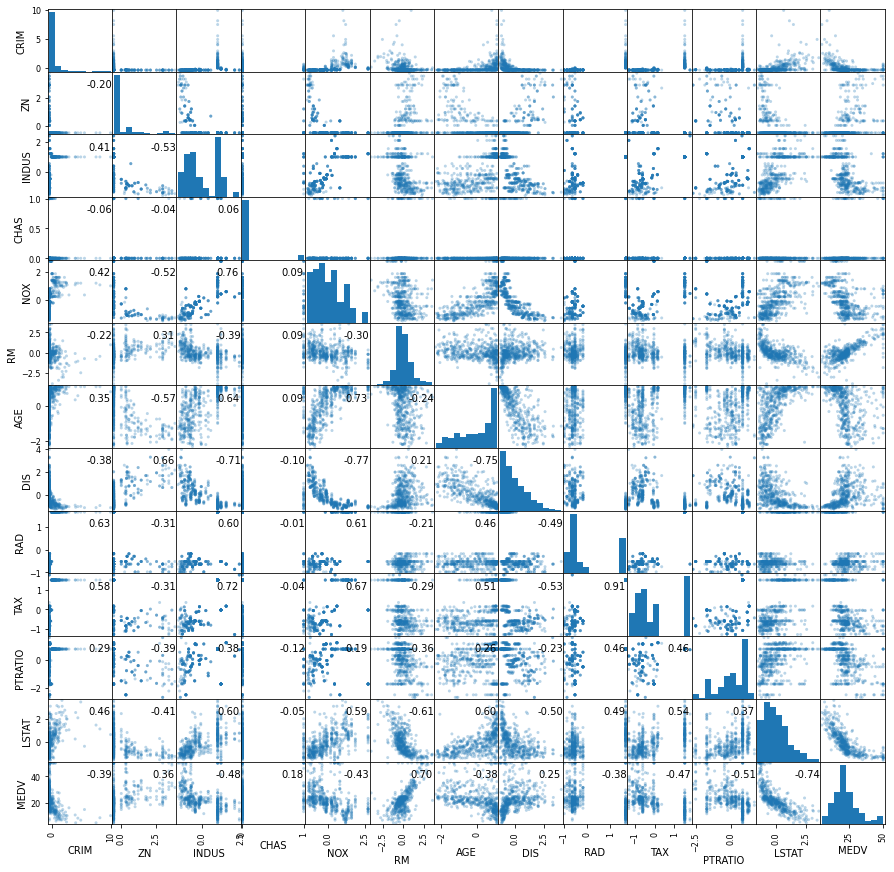

In [11]:
df_stnd
from pandas.plotting import scatter_matrix
axes = scatter_matrix(df_stnd.join(target), alpha=0.3, figsize=(15, 15), diagonal='hist')
corr = df_stnd.join(target).corr().values
for i, j in zip(*plt.np.tril_indices_from(axes, k=-1)):
    axes[i, j].annotate("%.2f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

X-matrix Condition Number (>30 is often considered cause for concern and points to multicolinearity or other matrix issues)

In [12]:
np.linalg.cond(df_stnd.values)

10.161776210598495

As a reference, here is the Condition Number before centering/standardizing

In [13]:
np.linalg.cond(df.values)

6767.008015700744

At this point, subject matter expertise and a bit of art comes into play as there appears to be some multicolinearity in the data.

Drop TAX as it is highly correlated with INDUS

In [14]:
df_stnd.drop(['TAX'], axis=1, inplace=True)

#### PCA

Use subject matter knowledge to group a few of the inputs into a neighborhood cluster.

Then we combine them using PCA and see how much of their collective variabiliity can be explained with one eigen-vector-based representation.

In [15]:
neighborhood = [ 'LSTAT', 'DIS', 'AGE', 'NOX', 'INDUS', 'ZN']

In [16]:
df_nbh = df_stnd[neighborhood]

In [17]:
# condition cluster
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pc = pca.fit_transform(df_nbh.values)
df_nbh_pca = pd.DataFrame(data = pc
             , columns = ['pc1', 'pc2', 'pc3'])
pca.explained_variance_ratio_

array([0.69051041, 0.10654449, 0.07781036])

In [18]:
df_nbh_pca.head(3)

,pc1,pc2,pc3
0,1.208415,-0.693172,-0.395065
1,0.660957,-0.675640,0.550026
2,1.188796,-1.151012,0.142047


In [19]:
# drop the neighborhood columns
df_stnd_pca = df_stnd.drop(neighborhood, axis=1)

# use the first PC as proxy for the clustered columns
# standardize it also
df_stnd_pca['NBH'] = (df_nbh_pca.pc1 - df_nbh_pca.pc1.mean()) / df_nbh_pca.pc1.std()
df_stnd_pca.head()

,CRIM,CHAS,RM,RAD,PTRATIO,NBH
0,-0.419367,0.0,0.413263,-0.981871,-1.457558,0.593684
1,-0.416927,0.0,0.194082,-0.867024,-0.302794,0.324722
2,-0.416929,0.0,1.281446,-0.867024,-0.302794,0.584045
3,-0.416338,0.0,1.015298,-0.752178,0.112920,1.004542
4,-0.412074,0.0,1.227362,-0.752178,0.112920,0.882698


After PCA, the correlation matrix and Condition Number look much better

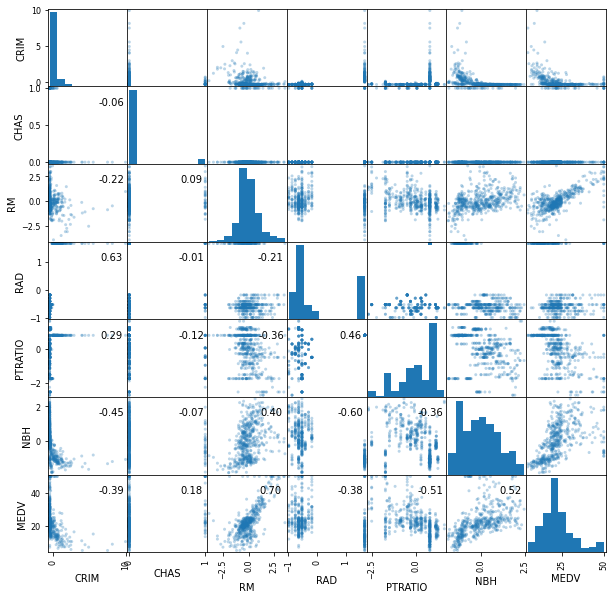

In [20]:
from pandas.plotting import scatter_matrix
axes = scatter_matrix(df_stnd_pca.join(target), alpha=0.3, figsize=(10, 10), diagonal='hist')
corr = df_stnd_pca.join(target).corr().values
for i, j in zip(*plt.np.tril_indices_from(axes, k=-1)):
    axes[i, j].annotate("%.2f" %corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')

In [21]:
np.linalg.cond(df_stnd_pca.values)

6.301105039932612

### Build the linear model

In [22]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_stnd_pca.values,target.values, test_size=0.15)
X_train = pd.DataFrame(X_train, columns=df_stnd_pca.columns)
y_train = pd.DataFrame(y_train, columns=target.columns)
X_test = pd.DataFrame(X_test, columns=df_stnd_pca.columns)
y_test = pd.DataFrame(y_test, columns=target.columns)

In [23]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     127.0
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           2.34e-91
Time:                        22:44:07   Log-Likelihood:                -1342.0
No. Observations:                 430   AIC:                             2698.
Df Residuals:                     423   BIC:                             2726.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1442      0.276     80.124      0.000      21.601      22.687
CRIM          -1.1612      0.326     -3.559      0.000      -1.802      -0.520
CHAS           4.5560      1.109      4.109      0.000       2.376       6.736
RM             4.5198      0.302     14.984      0.000       3.927       5.113
RAD            0.2183      0.409      0.534      0.593      -0.585       1.021
PTRATIO       -1.9384      0.322     -6.028      0.000      -2.570      -1.306
NBH            2.0063      0.361      5.550      0.000       1.296       2.717
==============================================================================
Omnibus:                      165.427   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              941.248
Skew:                           1.552   Prob(JB):                    4.08e-205
Kurtosis:                       9.550   Cond. No.                         6.87
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note that the effect of RAD is not statistically different than 0 so we should rerun the model without RAD included to get a cleaner representation of the model form.

In [24]:
# import statsmodels.api as sm
X_train.drop(['RAD'], axis=1, inplace=True)
X_test.drop(['RAD'], axis=1, inplace=True)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.643
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     152.6
Date:                Fri, 05 Aug 2022   Prob (F-statistic):           2.07e-92
Time:                        22:44:07   Log-Likelihood:                -1342.1
No. Observations:                 430   AIC:                             2696.
Df Residuals:                     424   BIC:                             2721.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1407      0.276     80.201      0.000      21.598      22.683
CRIM          -1.0757      0.284     -3.786      0.000      -1.634      -0.517
CHAS           4.5630      1.108      4.119      0.000       2.385       6.741
RM             4.5449      0.298     15.265      0.000       3.960       5.130
PTRATIO       -1.8815      0.303     -6.207      0.000      -2.477      -1.286
NBH            1.9259      0.328      5.865      0.000       1.280       2.571
==============================================================================
Omnibus:                      171.130   Durbin-Watson:                   2.024
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1005.792
Skew:                           1.603   Prob(JB):                    3.94e-219
Kurtosis:                       9.772   Cond. No.                         6.07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

RMSE for accuracy

In [25]:
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)
res_test = y_pred_test - y_test.MEDV.values
res_train = y_pred_train - y_train.MEDV.values

In [26]:
rmse_lin = np.sqrt(np.sum((res_test*res_test))/np.size(res_test))
print('RMSE', rmse_lin)

RMSE 6.3731964988119065


#### Residual Analysis

Before we can interpret the coefficients, we need to complete our assessment of the linear model assumptions by checking to see if the residuals are normally distributed (hist, normality test, and q-q plot) and free from heteroskedasticity (no spread in the pred by res plot).

Histogram and Normality test

NormaltestResult(statistic=171.13047006774417, pvalue=6.910199440141629e-38)


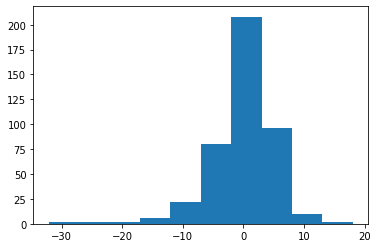

In [27]:
plt.hist(res_train)
from scipy import stats
print(stats.normaltest(res_train))

qqplot

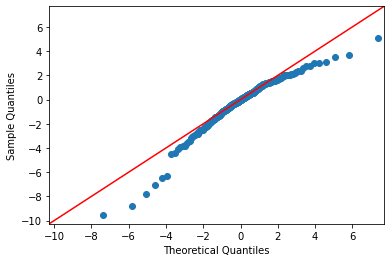

In [28]:
import scipy.stats as stats
fig = sm.qqplot(res_train, stats.t, fit=True, line='45')

pred by resid plot

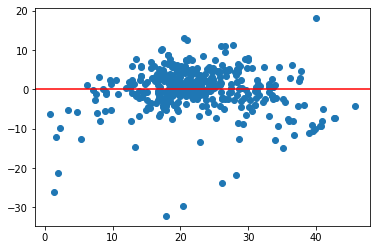

In [29]:
plt.scatter(y_pred_train, res_train)
plt.axhline(y=0, color='r', linestyle='-')

### Coefficient Analysis

Since we have fit a linear model and validated (at least we tried - there are known issues with this dataset) the assumptions of a linear model, we can now conduct an analysis of the coefficients.

Frist, get the coefficient table into a dataframe

In [30]:
df_coeffs = pd.read_html(model.summary().tables[1].as_html(),header=0,index_col=0)[0]
df_coeffs.drop(['const'], inplace=True) #drop the intercept

Next, find the minimum absolute value effect size for each variable based on 95% confidence

In [31]:
min95effect = []
for i, c in enumerate(df_coeffs.coef.values):
    if c == 0:
        min95effect.append(0)
    elif (df_coeffs['[0.025'].values[i] * df_coeffs['0.975]'].values[i]) < 0: #opposit signs
        min95effect.append(0)
    elif c < 0:
        min95effect.append(np.abs(df_coeffs['0.975]'].values[i]))
    elif c > 0:
        min95effect.append(np.abs(df_coeffs['[0.025'].values[i]))
    else:
        min95effect.append(99999)    
min95effect

[0.517, 2.385, 3.96, 1.286, 1.28]

Finalize the coefficients dataframe, sorting by the minimum absolute effect size under a 95% CI

In [32]:
df_coeffs['absmineffect'] = min95effect
df_coeffs.sort_values(['absmineffect'], ascending=False, inplace=True)
df_coeffs

,coef,std err,t,P>|t|,[0.025,0.975],absmineffect
RM,4.5449,0.298,15.265,0.0,3.960,5.130,3.960
CHAS,4.5630,1.108,4.119,0.0,2.385,6.741,2.385
PTRATIO,-1.8815,0.303,-6.207,0.0,-2.477,-1.286,1.286
NBH,1.9259,0.328,5.865,0.0,1.280,2.571,1.280
CRIM,-1.0757,0.284,-3.786,0.0,-1.634,-0.517,0.517


#### Interpret the coefficients 

-----Note that each new run's results may be slightly different due to the random train and test partition-----

Since the data has been scaled by it's stdev, we say that on average a one-stdev increase in RM will result in a 4.6K dollar increase in median house price *while holding the effect of all other variables in the study constant*. With 95 perc confidence we can say that the increase will be no less than 4.1K dollars. 

Similarly, for PTRATIO, we find that a one stdev increase in the pupil to teacher ratio will correspond with a 2K dollar decrease in median house price (at least 1.4K dollar decrease with 95 perc confidence) while holding the effect of all other variables constant. 

One can easily calculate the stdev for each variable to put this even more into a real world context.

***This is a powerful global explainability statement!***

Further we have sorted the variables by their lowest effect magnitude under 95 perc confidence so the table represents a variable importance table. We graph it below.

Finally, note that we cannot make any explainability statements about the variables in the NBH cluster, other than saying that collectively they represent at least a 1.2K dollar influence for every stdev change in their values. That is the price we have to pay in order to have a well specified model which allows us to confidently interpret at least some of the predictors.

Build the var imp graph

In [33]:
mask1 = df_coeffs.coef.values < 0
colors = np.array(['b']*len(df_coeffs))
colors[mask1] = 'r'

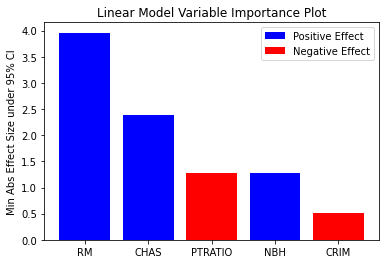

In [34]:
x=[0]
y=[0]
plt.bar(df_coeffs.index, df_coeffs.absmineffect, color = colors, label = 'Positive Effect')
plt.bar(x, y, color='red', label = 'Negative Effect') #just for the label
plt.title('Linear Model Variable Importance Plot')
plt.ylabel('Min Abs Effect Size under 95% CI')
plt.legend()

## Use a Black Box Approach with PDPs and Variable Importance

Build a gradient boosting model

In [35]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_stnd.values,target.values)
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)

/opt/conda/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GBR usually gives better prediction accuracy but less stable explainability.

In [36]:
y_pred = gbr.predict(X_test)
res = y_pred - y_test

This data lends itself well to a linear model. GBR overfits.

In [37]:
rmse_gbr = np.sqrt(np.sum((res*res))/np.size(res))
print('RMSE Lin', rmse_lin)
print('RMSE GBR', rmse_gbr)

RMSE Lin 6.3731964988119065
RMSE GBR 12.59559586796593


#### Traditional Var Imp Plots

If one believes that the linear model was a better fit (and the RMSE suggests such), then we can compare the var imp graphs below to that of the linear model above and note the kind of interpretation errors that we can get if we rely too heavily on GBR, and similar, var imp metrics. Still this is all based on many assumptions. It's good to compare to SHAP var imp plots as well.

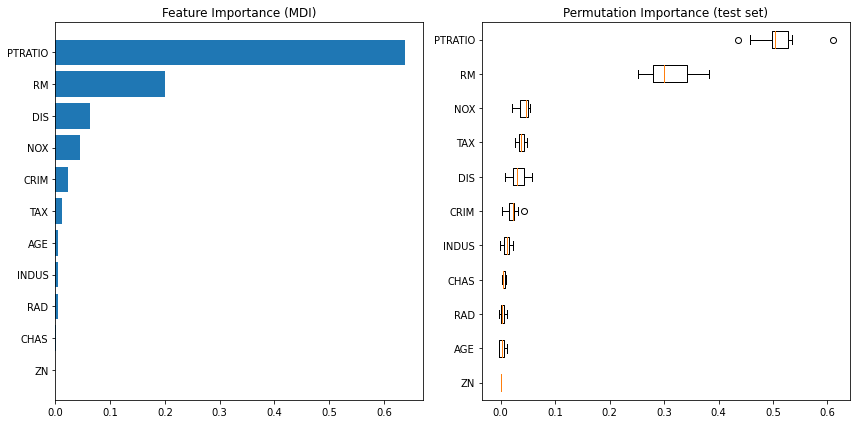

In [38]:
from sklearn.inspection import permutation_importance

feature_importance = gbr.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(df.columns)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(gbr, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(df.columns)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
# plt.show()

#### PDP

/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


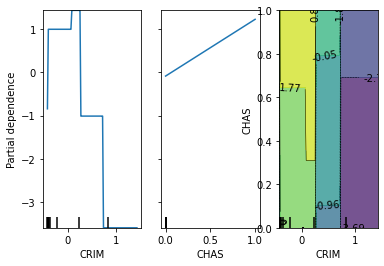

In [39]:
from sklearn.inspection import plot_partial_dependence

features = [0, 3, (0, 3)]
plot_partial_dependence(gbr, df_stnd, features) 

### ICE Plots

Individual Conditional Expectation (ICE) plots display one line per instance that shows how the instance's prediction changes when a feature changes.

##### install pycebox if needed

In [42]:
pip install pycebox

  Created wheel for pycebox: filename=pycebox-0.0.1-py3-none-any.whl size=3640 sha256=295a6a1a087e59963c460d784315ff67dcf3c7d78ff40da8e8ceaf5570a2243e
  Stored in directory: /home/ubuntu/.cache/pip/wheels/57/1d/11/7ff48510e0a4cc2caea58c2e4a69545ecb452c46f24fa101ae
Successfully built pycebox
Note: you may need to restart the kernel to use updated packages.


In [43]:
from matplotlib.cm import PuOr
import scipy as sp
import seaborn as sns

from pycebox.ice import ice, ice_plot

In [44]:
ice_df = ice(df_stnd, 'CRIM', gbr.predict, num_grid_points=100)

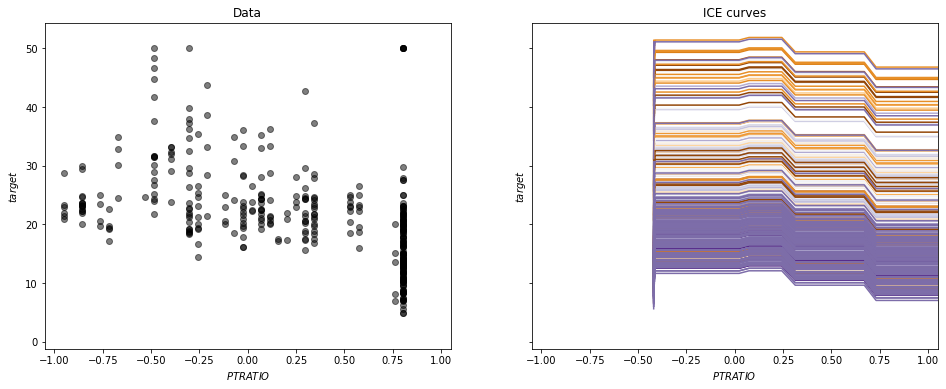

In [45]:
fig, (data_ax, ice_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(16, 6))

data_ax.scatter(df_stnd.PTRATIO, target.values, c='k', alpha=0.5);

data_ax.set_xlim(-1.05, 1.05);
data_ax.set_xlabel('$PTRATIO$');

data_ax.set_ylabel('$target$');

data_ax.set_title('Data');

# ice_plot(ice_df, frac_to_plot=1,
#          c='k', alpha=0.25,
#          ax=ice_ax);

ice_plot(ice_df, frac_to_plot=1,
         color_by='PTRATIO', cmap=PuOr,
         ax=ice_ax);

ice_ax.set_xlabel('$PTRATIO$');

ice_ax.set_ylabel('$target$');

ice_ax.set_title('ICE curves');